## Lab 5 - Categorization

This lab must be done **individually**. The required packages have been imported for you below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial  
from sklearn.model_selection import LeaveOneOut

Data adapted from Leuven Concept Database (De Deyne et al., 2008).

Extract data from file.

In [2]:
df = pd.read_csv('data-categorization.csv')

Get feature list.

In [3]:
features = list(df.features)
features.remove('category')

Get names of all animals.

In [4]:
names = list(df); del names[0]

Get binary feature matrix (animal-by-feature).

In [5]:
F = pd.read_csv("data-categorization.csv", header=0, usecols=list(np.arange(1,54)))
F = np.asarray(F)

Get category labels.

In [6]:
labels = F[len(F)-1,:]
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Config `F` such that each row is feature vector of one animal.

Each column is either a bird (category label = 0) or a fish (category label = 1).

In [7]:
F = np.delete(F,len(F)-1,0) 
F = np.transpose(F) #this gives us the animal with all of its feature values as opposed to all the features with all the animal's value. 
print(F[0]) 


[0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0
 1 0 1 0 0 0 0]


You should have the following variables:

(**Hint**: Print them out to see what they are).

1. Main variables you'll need for analysis:
    - `F`:        53-by-44 binary matrix, i.e. 53 animal exemplars (30 birds and 23 fish) and 44 features
    - `labels`:   53 binary category labels (0 for bird; 1 for fish), i.e. ground truth that you'll predict
    
    
2. Auxillary variables
    - `names`:    53 animal names
    - `features`: 44 feature names
    
In this lab, you will implement, evaluate, and analyze two models of categorization, based on the prototype and exemplar theories. You will test these models against a dataset of birds and fish, features and category labels of which have been provided in the matrix and array processed for you (see above). 

You will first be guided through a non-assessed visualization, via multi-dimensional scaling (MDS)---this will offer you an intuition of the data you work with in a 2D space. You will then implement each of the two models, evaluate them in leave-one-out-cross-validation (as discussed in class), and interpret the errors made by each model.

### Data visualization (not assessed)

Run the code below to visualize the animals in two dimensions, via multi-dimensional scaling.

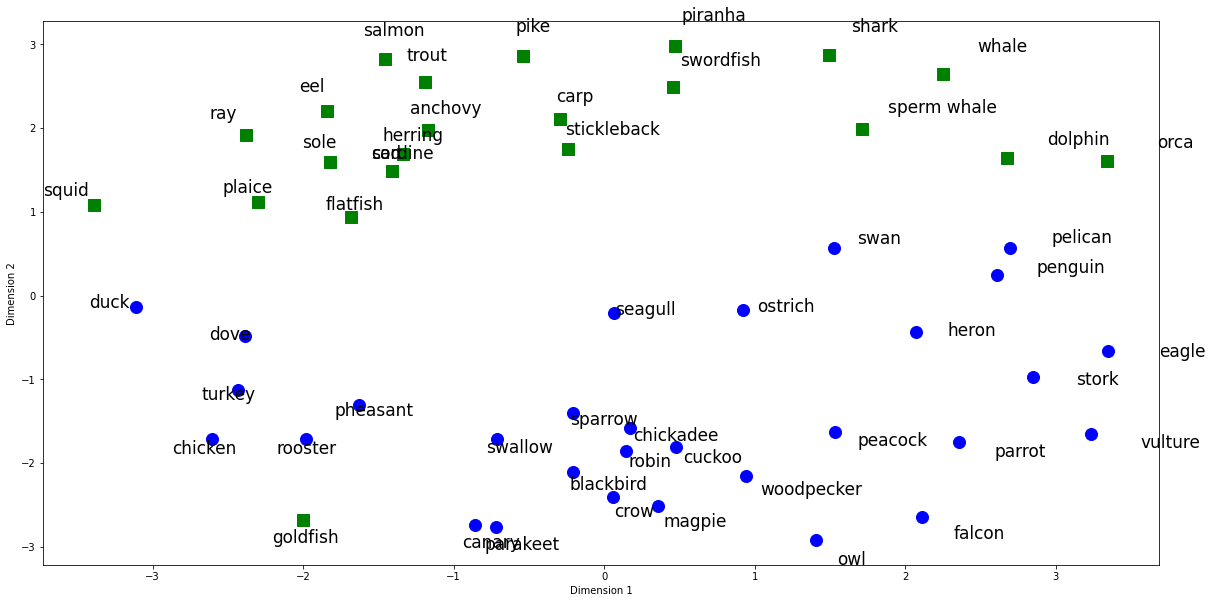

In [8]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
F_lowdim = embedding.fit_transform(F)

birdinds = np.where(labels==0)
fishinds = np.where(labels==1)

fig = plt.figure(figsize=(20, 10))
plt.plot(F_lowdim[birdinds,0],F_lowdim[birdinds,1],'bo',markersize=12)
plt.plot(F_lowdim[fishinds,0],F_lowdim[fishinds,1],'gs',markersize=12)

for i in range(0,len(F)):
    plt.text(F_lowdim[i,0]*1.1,F_lowdim[i,1]*1.1,names[i],fontsize=17)
    
plt.xlabel('Dimension 1')    
plt.ylabel('Dimension 2')    

plt.show()

### Tasks 1-3 [10 pts] 
**Task 1**: Evaluate each model by standard leave-one-animal-out cross validation. **[2 pts]**

**Task 2**: Implement two models of categorization: a prototype model **[2pts]** and an exemplar model **[2pts]**.

**Task 3**: Report predictive accuracy of each model in percentage (i.e. % correct predictions out of 53 animals). **[1 pt]**

**Task 4**: Perform an error analysis on the two models (i.e. report which exemplars each model failed on), then compare and discuss why the errors look the way they do. **[3 pts]**


**Hint:** Consider using the following wrapper code for performing the leave-one-out (LOO) cross validation.

You may also want to refer to description and example code here: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html

In [57]:
loo = LeaveOneOut()
loo.get_n_splits(F)

prototype_pass = 0 
exemplar_pass = 0

prototype_fail = []
exemplar_fail = []

for train_index, test_index in loo.split(F):
    

#     1) Get training and testing data points
    F_train, F_test = F[train_index], F[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # get indexes for birds and fishes we're training on
    birdinds = np.where(y_train == 0)
    fishinds = np.where(y_train == 1)
    
    # isolate the birds from the fishes using the indices we found previously 
    #     and construct our training set of birds and fishes
    bird_train = [F_train[x] for x in birdinds]
    fish_train = [F_train[x] for x in fishinds]
    
     
#     2.1) Implement and predict with prototype model

    # Create prototypes out of the birds and fishes we're training on.
    bird_proto = np.mean(bird_train, axis = 1)
    fish_proto = np.mean(fish_train, axis = 1)
    
    # Calculate distances from prototypes to test vector. 
    dist_birdproto = spatial.distance.euclidean(bird_proto, F_test[0])
    dist_fishproto = spatial.distance.euclidean(fish_proto, F_test[0])
    
    prediction_proto = 0 if (dist_fishproto > dist_birdproto) else 1 
     
    # If distances to each prototype is equal, flip a coin to decide it's category.
    if dist_fishproto == dist_birdproto:
        prediction_proto = np.random.binomial(1, 0.50)
    
    if prediction_proto == y_test:
        prototype_pass += 1
    else:
        prototype_fail.append((F_test[0]))
    
#     2.2) Implement and predict with exemplar model
    
    ### Calculating bird exemplar similarity 
    dist_birdexemplars = np.array([spatial.distance.euclidean(bird, F_test[0]) for bird in bird_train[0]])
    
    #print (dist_birdexemplars)
    
    # Similarity function is e^(-distance^2)
    sim_allbirds = np.exp(-dist_birdexemplars**2)
    
    sim_bird = np.sum(sim_allbirds) / len(bird_train[0])
    
    
    ### Calculating fish exemplar similarity 
    dist_fishexemplars = np.array([spatial.distance.euclidean(fish, F_test[0]) for fish in fish_train[0]])
    
    #print (dist_birdexemplars)
    
    # Similarity function is e^(-distance^2)
    sim_allfish = np.exp(-dist_fishexemplars**2)
    
    sim_fish = np.sum(sim_allfish) / len(fish_train[0])
    
    
    
    prediction_exemplar = 0 if (sim_bird > sim_fish) else 1 
    
    # If distances to each prototype is equal, flip a coin to decide it's category.
    if sim_bird == sim_fish:
        prediction_exemplar = np.random.binomial(1, 0.50)
        
    if prediction_exemplar == y_test:
        exemplar_pass += 1
    else:
        exemplar_fail.append((F_test[0]))
        
    

# 3) Report predictive accuracies (%)

print ("Prototype model accuracy: ", prototype_pass / 53 , "%")
print ("Prototype model failures: ", len(prototype_fail), "fails")

#I don't prefer the usage of nested for-loops but since there are only a few errors then this will suffice, but I acknowledge the potential inefficiency here. 
for fail in prototype_fail:
    for (col_name, col_data) in df.iteritems():
        comparison = np.array(col_data)[:-1] == fail
        equal_arrays = comparison.all()
        if equal_arrays:
            print ("Prototype model failed on: ", col_name)

print ("Exemplar model accuracy: ", exemplar_pass / 53 , "%")
print ("Exemplar model failures: ", len(exemplar_fail), "fails")

for fail in exemplar_fail:
    for (col_name, col_data) in df.iteritems():
        comparison = np.array(col_data)[:-1] == fail
        equal_arrays = comparison.all()
        if equal_arrays:
            print ("Exemplar model failed on: ", col_name)
    

Prototype model accuracy:  0.9433962264150944 %
Prototype model failures:  3 fails
Prototype model failed on:  duck
Prototype model failed on:  goldfish
Prototype model failed on:  orca
Exemplar model accuracy:  0.9622641509433962 %
Exemplar model failures:  2 fails
Exemplar model failed on:  dolphin
Exemplar model failed on:  goldfish


**Task 4**: Perform an error analysis on the two models (i.e. report which exemplars each model failed on), then compare and discuss why the errors look the way they do.

For the prototype model, it failed when testing for the duck, goldfish and orca, and the Exemplar model failed when testing for the dolphin and goldfish. Both models failed at testing for the goldfish, and if we look at the Multi-dimensional scaling of our feature matrix, we can see that in 2 dimensions, the goldfish is situated in spot far away from its fellow fish exemplars. So, regardless of if you used a prototype model or exemplar model, the goldfish is closer in distance or more similar to the prototypical bird or bird exemplars, respectively. The prototype model also failed on the duck and the orca. Both the duck and the orca, on the MDS visualization, are on the boundaries of their respective categories. A prototype constructed of either category will result in a prototype that is the a significant distance away from its boundaries. This opens up the opportunity for another prototype of another category to be slightly closer to our novel test object, leading to the category mistake. The exemplar model failed on the dolphin, and again we see that the dolphin's position on the MDS visualization is one that is far from its fellow fish exemplars, and also close to a large cluster of birds. When calculating the average distance from each exemplar to the dolphin, the dolphin is much closer to more birds than fish, allowing for dolphin to be mistakenly taken as more similar to birds than fish. The common thread between all errors, besides the duck whose position is very contradictory to common knowledge, is that objects were on the boundaries of their respective categories and happened to be closer to more exemplars of the other category than exemplars of their own category.   


Export and submit a **fully executable** Python Jupyter Notebook and a PDF copy of your notebook showing all results. 